In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('image', cmap='gray')
import cv2
import os
import math
import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Activation,
                                    Flatten, Dense, Reshape, Dropout, Add, Input)
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from sklearn.metrics import roc_curve, roc_auc_score
import random
import pickle
import sys

In [163]:
# TODO: make this more OOP-like. Also add uncertainty option for mobilenet version
class AEUnet:
    @staticmethod
    def collin(dim=256,depth=1,filters=(16,32,64,128,256),latentDepth=512,MCDropout=False):
        '''
        dim: dim of square input image
        depth: number of channels in input image
        filters: tuple for set of convolution filters, defaulted to paper implementation
        latentDepth: depth of latent layer
        '''
        inputShape=(dim,dim,depth)
        chanDim=-1 #channel dimension (-1) applies batch norm for each layer (or depth) Unknowns=[mu(untrainable),sigma(untrainable),gamma,beta]*depth

        inputs = Input(shape=inputShape)
        x = inputs

        # generate:conv=>relu=>bn layers
        # additionally, save skip connections and add dropout
        # Dropout layers increase by 0.1 as the encoder gets deeper
        skips = []
        for i, f in enumerate(filters):
            x = Conv2D(f,(5,5),strides=2,padding='same')(x)
            x1 = [x]
            skips.append(x1[0])
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x) 
            x = Dropout(0.1 * i)(x, training=MCDropout)

        # For the UNet build, use a conv layer instead of dense for latent
        latent = Conv2D(latentDepth, (5, 5), strides=2, padding='same', name='latent')(x)
        y = latent
        
        #decode the latent space, incorporating skip layers
        for i, f in reversed(list(enumerate(filters))):
            y = Conv2DTranspose(f,(5,5),strides=2,padding='same')(y)
            y = Add()([skips[i], y])
            y = LeakyReLU(alpha=0.2)(y)
            y = BatchNormalization(axis=chanDim)(y)

        
        # Technically not strictly following the paper, this should be a straight-up upsampling
        y = Conv2DTranspose(depth,(5,5),strides=2,padding='same')(y)
        outputs = Activation('sigmoid')(y)
        autoencoder = Model(inputs,outputs,name='autoencoder')

        return autoencoder

    def mobilenet(output_channels, input_dim):

        base_model = tf.keras.applications.MobileNetV2(input_shape=[input_dim, input_dim, 3], include_top=False)

        # Use the activations of these layers
        layer_names = [
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16
            'block_13_expand_relu',  # 8x8
            'block_16_project',      # 4x4
        ]
        layers = [base_model.get_layer(name).output for name in layer_names]

        # Create the feature extraction model
        down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
        down_stack.trainable = True # From TLP experience, this should be True

        # "Add" layer version
        up_stack = [
            pix2pix.upsample(576, 3),  # 4x4 -> 8x8
            pix2pix.upsample(192, 3),  # 8x8 -> 16x16
            pix2pix.upsample(144, 3),  # 16x16 -> 32x32
            pix2pix.upsample(96, 3),   # 32x32 -> 64x64
        ]

#         # "Concat" layer version
#         up_stack = [
#             pix2pix.upsample(512, 3),  # 4x4 -> 8x8
#             pix2pix.upsample(256, 3),  # 8x8 -> 16x16
#             pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#             pix2pix.upsample(64, 3),   # 32x32 -> 64x64
#         ]

        inputs = tf.keras.layers.Input(shape=[input_dim, input_dim, 3])
        x = inputs

        # Downsampling through the model
        skips = down_stack(x)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            # swap concat for add
            add = tf.keras.layers.Add()
            x = add([x, skip])

        # This is the last layer of the model
        last = tf.keras.layers.Conv2DTranspose(
            output_channels, 3, strides=2,
            padding='same')(x)  #64x64 -> 128x128

        # Modification to make autoencoder
        outputs = Activation('sigmoid')(last)
        autoencoder = Model(inputs,outputs,name='autoencoder')

        return autoencoder
    
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [168]:
create_autoencoder(MCDropout=True)

In [159]:
from random import randint, uniform
from numpy.random import normal, uniform
from skimage.util import random_noise
from skimage.filters import threshold_otsu
from skimage.draw import ellipse_perimeter, disk
from scipy.interpolate import interp1d 
from scipy.ndimage import gaussian_filter

#!!! If blur is too high (0.08), then it won't get real defects good
def add_stain(img,
              min_size=10,
              max_size=40,
              min_color=0.,
              max_color=255.,
              cx_range=None,
              cy_range=None,
              irregularity=0.02,
              blur=0.02):
    '''
    Draw an ellipse-like shape 
    INPUT : 
        - img: image to corrupt with an elliptical stain
        - min_size, max_size: bounds for stain size in percentage
        - min_color, max_color: bounds of intensities to sample from (0 - 255)
        - cx_range, cy_range: (optional) tuples to constrain location (in percentage of image) of stain center
        - irregularity: level of irregularity of the ellipse (0: no)
        - blur: blur edges (0: no)
    OUTPUT: 
        - corrupted image
    '''
    
    assert min_size <= max_size, 'min_size must not be greater than max_size'
    assert min_size >= 0 and max_size <= 100, 'invalid sizes. Must be in range [0, 100]'
    assert min_color <= max_color, 'min_color must not be greater than max_color'
    assert max_color >= 0 and max_color <= 255, 'invalid colors, Must be in range[0, 255]'

    color    = randint(min_color, max_color)
    col, row = img.shape[1], img.shape[0]
    rotation = uniform(0, 2*np.pi)
    ax_x = int(randint(min_size, max_size)/2 / 100*col)
    ax_y = int(randint(min_size, max_size)/2 / 100*row)
    
    if cx_range is not None:
        cx_lower = int(cx_range[0] / 100.*col)
        cx_upper = int(cx_range[1] / 100.*col)
    else:
        cx_lower = int(max_size/2 / 100.*col)
        cx_upper = int((100 - max_size/2) / 100.*col)
        
    if cy_range is not None:
        cy_lower = int(cy_range[0] / 100.*row)
        cy_upper = int(cy_range[1] / 100.*row)
    else:
        cy_lower = int(max_size/2 / 100.*row)
        cy_upper = int((100 - max_size/2) / 100.*row)
    
    cx, cy = randint(cx_lower, cx_upper), randint(cy_lower, cy_upper)
    y,x      = ellipse_perimeter(cy, cx, ax_y, ax_x, rotation)
    # Flip x and y because opencv is annoying
    contour  = np.array([[i,j] for i,j in zip(x,y)])
    # Change the shape of the ellipse 
    if irregularity > 0: 
        contour = _perturbate_ellipse(contour, cx, cy, (ax_x+ax_y)/2, irregularity)

    mask = np.zeros((row, col)) 
    mask = cv2.drawContours(mask, [contour], -1, 1, -1)

    if blur != 0 : 
        mask = gaussian_filter(mask, max(ax_x,ax_y)*blur)

    rgb_mask     = np.dstack([mask]*3)
    not_modified = np.subtract(np.ones(img.shape), rgb_mask)
    stain        = 255*random_noise(np.zeros(img.shape), mode='gaussian', mean = color/255., var = 0.05/255.)
    result       = np.add( np.multiply(img,not_modified), np.multiply(stain,rgb_mask) ) 

    return result.astype(np.uint8)

'''
Helper functions for stain
'''
def _perturbate_ellipse(contour, cx, cy, diag, irregularity):
    # Keep only some points
    if len(contour) < 20: 
        pts = contour
    else: 
        pts = contour[0::int(len(contour)/20)]

    # Perturbate coordinates
    for idx,pt in enumerate(pts): 
        pts[idx] = [pt[0]+randint(-int(diag*irregularity), int(diag*irregularity)),
                    pt[1]+randint(-int(diag*irregularity),int(diag*irregularity))]
    pts = sorted(pts, key=lambda p: _clockwiseangle(p, cx, cy))
    pts.append([pts[0][0], pts[0][1]])

    # Interpolate between remaining points
    i = np.arange(len(pts))
    interp_i = np.linspace(0, i.max(), 10 * i.max())
    yi = interp1d(i, np.array(pts)[:,0], kind='cubic')(interp_i)
    xi = interp1d(i, np.array(pts)[:,1], kind='cubic')(interp_i) 
 
    return np.array([[int(i),int(j)] for i,j in zip(yi,xi)])

def _clockwiseangle(point, cx, cy):
    refvec = [0 , 1]
    vector = [point[0]-cy, point[1]-cx]
    norm   = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if norm == 0:
        return -math.pi
    normalized = [vector[0]/norm, vector[1]/norm]
    dotprod    = normalized[0]*refvec[0] + normalized[1]*refvec[1] 
    diffprod   = refvec[1]*normalized[0] - refvec[0]*normalized[1] 
    angle      = math.atan2(diffprod, dotprod)
    if angle < 0:
        return 2*math.pi+angle
    return angle

In [66]:
# Configs
DIM = 256
DATA_DIR = 'data/mvtec_anomaly_detection/carpet/train/good/'
EPOCHS = 1000
INIT_LR = 1e-3
BS = 8
LOSS = 'mse'
testImg = 'data/mvtec_anomaly_detection/carpet/test/hole/000.png'
modelSavePath = 'outputs/prototype.pb'
historySavePath = 'outputs/prototype_history'
def create_autoencoder():
    return AEUnet.mobilenet(3, DIM)
STAIN_PROPS = [10, 40, 0, 255]

In [67]:
# Same as Prototype but for only 100 epochs, as 50 was where things were really good in the last
DIM = 256
DATA_DIR = 'data/mvtec_anomaly_detection/carpet/train/good/'
EPOCHS = 100
INIT_LR = 1e-3
BS = 8
LOSS = 'mse'
testImg = 'data/mvtec_anomaly_detection/carpet/test/hole/000.png'
modelSavePath = 'outputs/prototype1.pb'
historySavePath = 'outputs/prototype1_history'
def create_autoencoder():
    return AEUnet.mobilenet(3, DIM)
STAIN_PROPS = [10, 40, 0, 255]

In [68]:
# Same as Prototype but for only 100 epochs, and less aggro stain colors
DIM = 256
DATA_DIR = 'data/mvtec_anomaly_detection/carpet/train/good/'
EPOCHS = 100
INIT_LR = 1e-3
BS = 8
LOSS = 'mse'
testImg = 'data/mvtec_anomaly_detection/carpet/test/hole/000.png'
modelSavePath = 'outputs/prototype2.pb'
historySavePath = 'outputs/prototype1_history'
def create_autoencoder():
    return AEUnet.mobilenet(3, DIM)
STAIN_PROPS = [10, 40, 150, 200]

In [192]:
# Collin carpet
DIM = 256
DATA_DIR = 'data/mvtec_anomaly_detection/carpet/train/good/'
EPOCHS = 300
INIT_LR = 1e-3
BS = 16
LOSS = 'mse'
testImgs = [
    'data/mvtec_anomaly_detection/carpet/test/cut/000.png',
    'data/mvtec_anomaly_detection/carpet/test/hole/000.png',
    'data/mvtec_anomaly_detection/carpet/test/metal_contamination/000.png',
    'data/mvtec_anomaly_detection/carpet/test/thread/000.png',
    'data/mvtec_anomaly_detection/carpet/test/color/000.png',
    'data/mvtec_anomaly_detection/carpet/test/good/000.png'
]
modelSavePath = 'outputs/collin_carpet.pb'
historySavePath = 'outputs/collin_history'
create_autoencoder = AEUnet.collin
STAIN_PROPS = [10, 40, 0, 255]

In [182]:
# Collin bottle
DIM = 256
DATA_DIR = 'data/mvtec_anomaly_detection/bottle/train/good/'
EPOCHS = 300
INIT_LR = 1e-3
BS = 16
LOSS = 'mse'
testImgs = [
    'data/mvtec_anomaly_detection/bottle/test/broken_large/000.png',
    'data/mvtec_anomaly_detection/bottle/test/broken_large/001.png',
    'data/mvtec_anomaly_detection/bottle/test/broken_small/000.png',
    'data/mvtec_anomaly_detection/bottle/test/broken_small/001.png',
    'data/mvtec_anomaly_detection/bottle/test/contamination/000.png',
    'data/mvtec_anomaly_detection/bottle/test/good/000.png'
]
modelSavePath = 'outputs/collin_bottle.pb'
historySavePath = 'outputs/collin_history/bottle'
create_autoencoder = AEUnet.collin
STAIN_PROPS = [10, 40, 0, 255]

In [41]:
autoencoder = AEUnet.mobilenet(3, DIM)

In [183]:
def stain_wrapper(image, target):
    image = image.numpy()
    target = target.numpy()
    image = add_stain(image, STAIN_PROPS[0], STAIN_PROPS[1], STAIN_PROPS[2], STAIN_PROPS[3])
    image = np.expand_dims(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), axis=-1)
    target = np.expand_dims(cv2.cvtColor(target, cv2.COLOR_BGR2GRAY), axis=-1)
    return image.astype('float32') / 255, target.astype('float32') / 255

stain_lambda = lambda x, y: tf.py_function(stain_wrapper, [x, y], ['float32', 'float32'])

In [184]:
# data input pipeline
imgDir = os.listdir(DATA_DIR)
# Note: not grayscale!!!

imgs = np.empty((len(imgDir), DIM, DIM, 3), dtype='uint8')
for i, imgName in enumerate(imgDir):
    img = cv2.imread(os.path.join(DATA_DIR, imgName))
    img = cv2.resize(img, (256, 256))
    imgs[i] = img

(trainX, valX)=train_test_split(imgs,test_size=0.2,random_state=42)

trainData = tf.data.Dataset.from_tensor_slices((trainX, trainX))\
            .prefetch(tf.data.experimental.AUTOTUNE)\
            .map(stain_lambda)\
            .shuffle(trainX.shape[0])\
            .batch(BS)
            
valData   = tf.data.Dataset.from_tensor_slices((valX, valX))\
            .prefetch(tf.data.experimental.AUTOTUNE)\
            .map(stain_lambda)\
            .batch(BS)

shape0 (256, 256, 1)
shape1 (256, 256, 1)
shape0 (256, 256, 1)
shape1 (256, 256, 1)
shape0 (256, 256, 1)
shape1 (256, 256, 1)
shape0 (256, 256, 1)
shape1 (256, 256, 1)
shape0 (256, 256, 1)
shape1 (256, 256, 1)
shape0 (256, 256, 1)
shape1 (256, 256, 1)
shape0 (256, 256, 1)
shape1 (256, 256, 1)


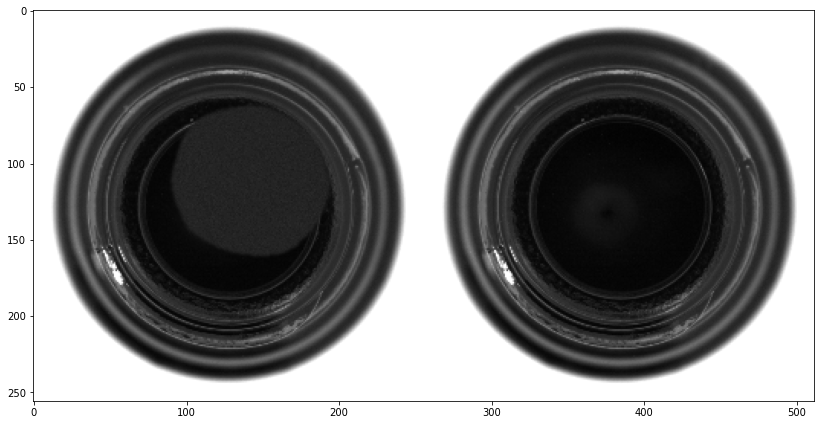

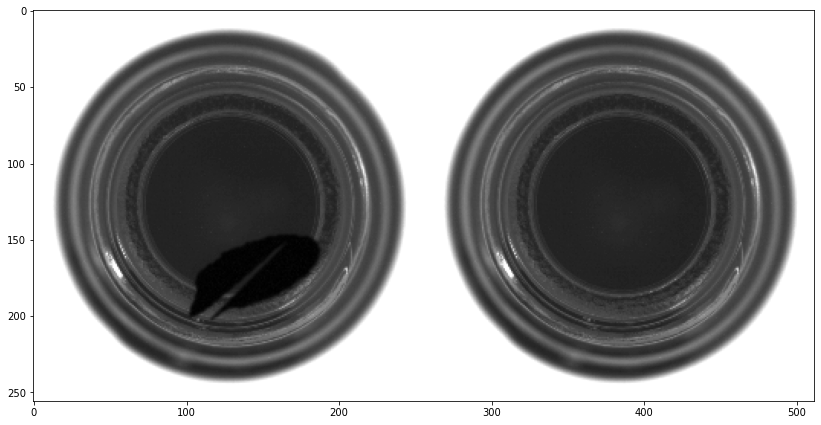

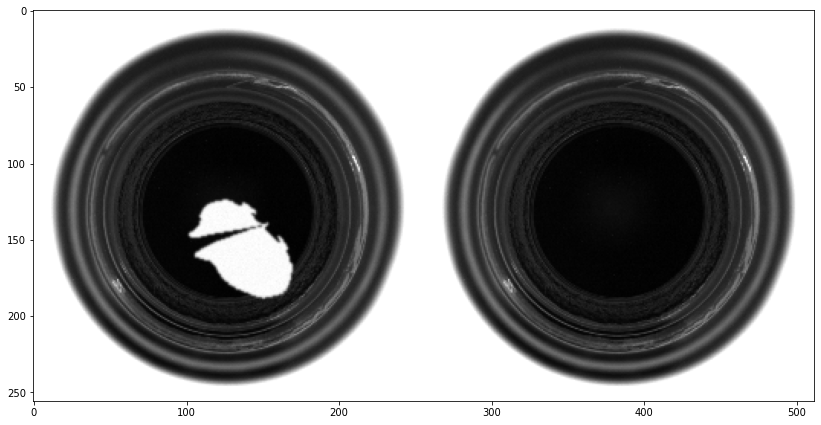

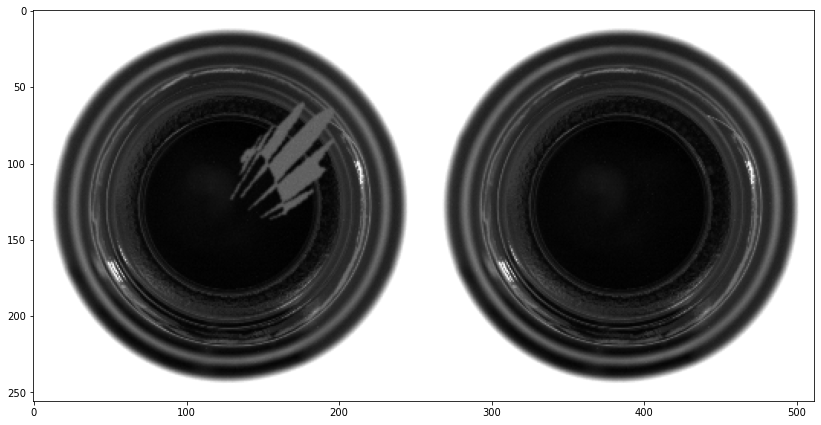

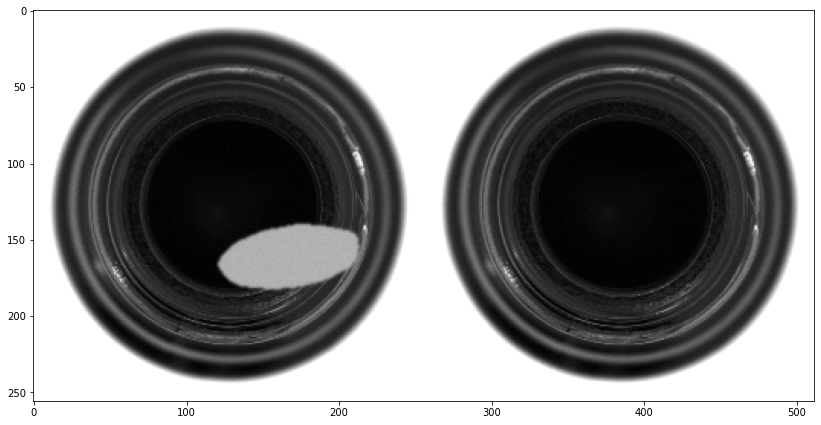

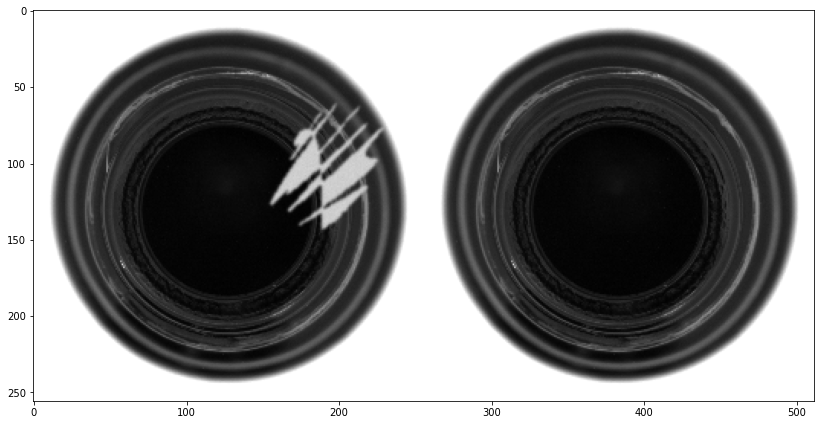

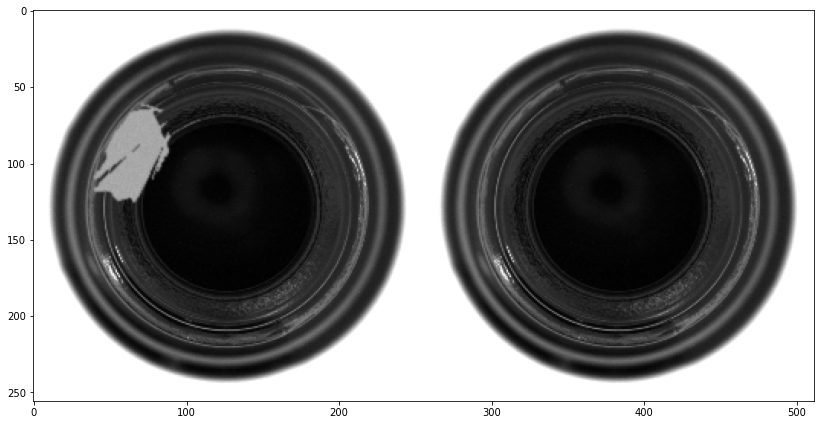

In [185]:
# Sanity check
for i, data in enumerate(trainData):
    plt.figure(figsize=(14,14))
    print('shape0', data[0][0].shape)
    print('shape1', data[1][0].shape)
    plt.imshow(np.hstack((data[0][0], data[1][0])))
    if i > 5:
        break

In [8]:
len(imgDir)

280

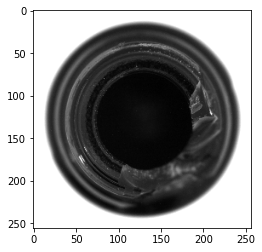

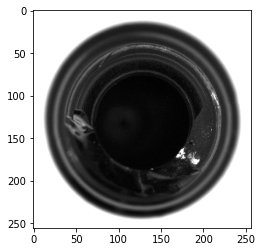

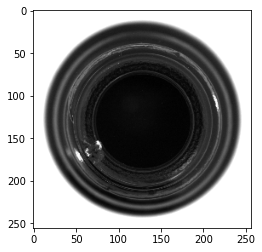

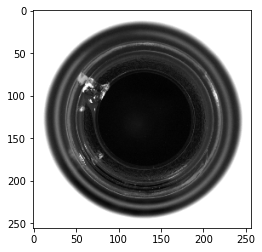

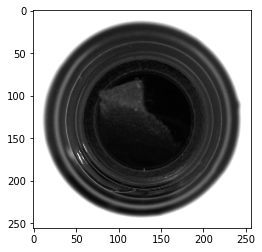

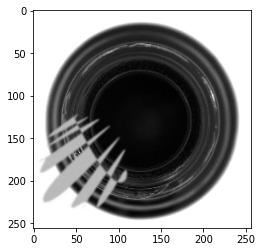

In [186]:
# Grab a few for testing
visImages = np.empty((6, DIM, DIM, 1))
for i, path in enumerate(testImgs):
    img = cv2.imread(path)
    if i == 5:
        img = add_stain(img, STAIN_PROPS[0], STAIN_PROPS[1], STAIN_PROPS[2], STAIN_PROPS[3])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (DIM, DIM))
    visImages[i] = np.expand_dims(img, axis=[0, -1]).astype('float32') / 255
    plt.imshow(visImages[i])
    plt.show()

## Things to Try After Baseline

### First
- Benchmark AMUnet

### Easy
- Adabound optimizer
- More aggro synthetic defect suite
- SSIM loss
- Uncertainty vs Residual
    - Are you serious. Uncertainty is literally just running the model 30 times with the dropout layers active.
    - There is a workaround here https://github.com/keras-team/keras/issues/9412#issuecomment-366487249 but I don't understand it and think I tried it already? Looks like (from the lower comments) people have had trouble with it in new TF. Here is my proposed workflow: Define a new model with MC dropout (aka train=True) and port over the weights.

### Research
- Energy method

### More Benchmarking
- VAE
- L2 Autoencoder
- DeepLab-based
- Other segmentation-based


[INFO] building autoencoder...
Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 416         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          leaky_re_lu[0][0]                
_________________________________________________________

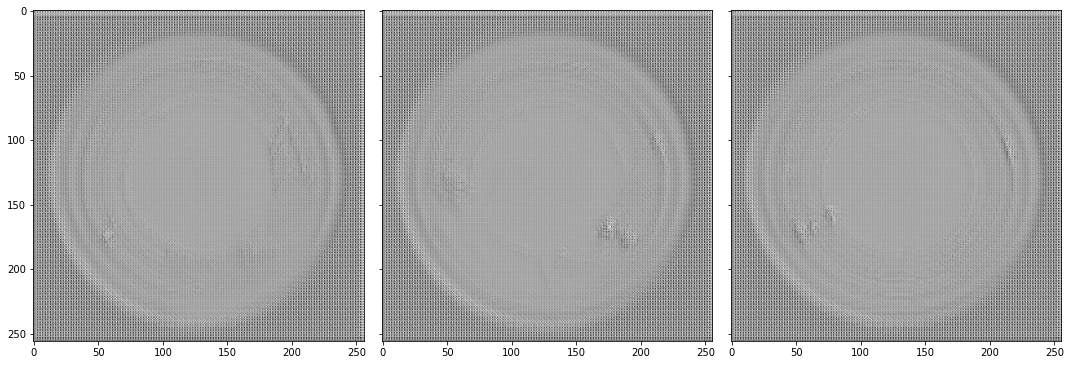

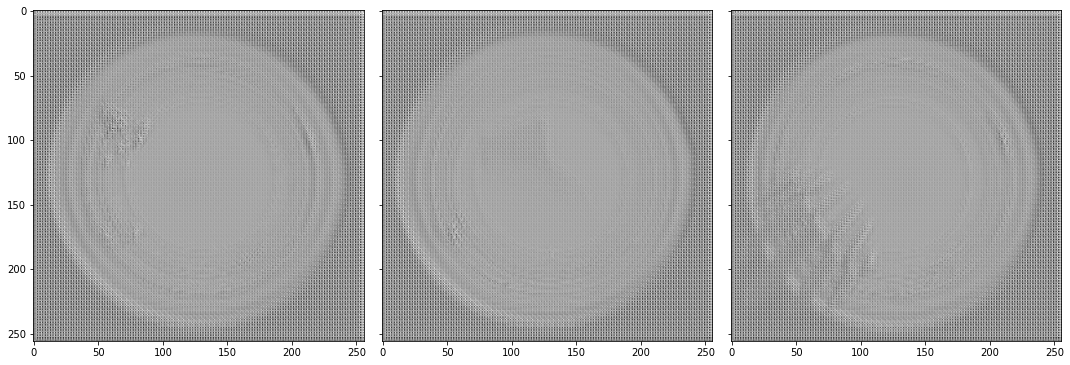


Sample Prediction after epoch 1

Epoch 1/300
11/11 [==============================] - 8s 720ms/step - loss: 0.0453 - val_loss: 0.0935
Epoch 2/300
11/11 [==============================] - 8s 684ms/step - loss: 0.0105 - val_loss: 0.0255
Epoch 3/300
11/11 [==============================] - 7s 639ms/step - loss: 0.0078 - val_loss: 0.0378
Epoch 4/300
11/11 [==============================] - 7s 644ms/step - loss: 0.0059 - val_loss: 0.0486
Epoch 5/300
11/11 [==============================] - 7s 641ms/step - loss: 0.0050 - val_loss: 0.0444
Epoch 6/300
11/11 [==============================] - 7s 646ms/step - loss: 0.0044 - val_loss: 0.0569
Epoch 7/300
11/11 [==============================] - 7s 643ms/step - loss: 0.0039 - val_loss: 0.0666
Epoch 8/300
11/11 [==============================] - 7s 635ms/step - loss: 0.0035 - val_loss: 0.0749
Epoch 9/300
11/11 [==============================] - 7s 645ms/step - loss: 0.0032 - val_loss: 0.0726
Epoch 10/300
11/11 [==============================] - 7s 

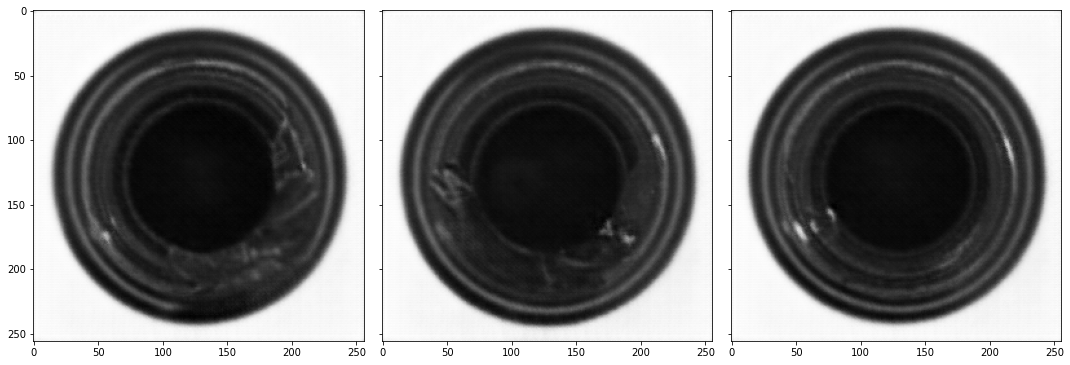

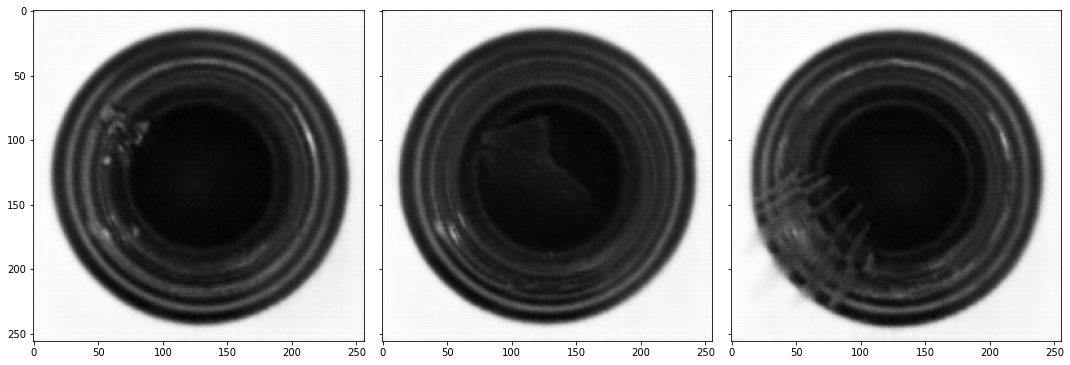


Sample Prediction after epoch 51

Epoch 51/300
11/11 [==============================] - 8s 685ms/step - loss: 6.6629e-04 - val_loss: 0.0015
Epoch 52/300
11/11 [==============================] - 7s 634ms/step - loss: 6.7694e-04 - val_loss: 0.0017
Epoch 53/300
11/11 [==============================] - 7s 681ms/step - loss: 6.7282e-04 - val_loss: 0.0014
Epoch 54/300
11/11 [==============================] - 7s 643ms/step - loss: 6.6689e-04 - val_loss: 0.0014
Epoch 55/300
11/11 [==============================] - 7s 658ms/step - loss: 6.6211e-04 - val_loss: 0.0016
Epoch 56/300
11/11 [==============================] - 7s 674ms/step - loss: 6.5907e-04 - val_loss: 9.1912e-04
Epoch 57/300
11/11 [==============================] - 7s 640ms/step - loss: 6.6489e-04 - val_loss: 0.0018
Epoch 58/300
11/11 [==============================] - 7s 681ms/step - loss: 6.8991e-04 - val_loss: 8.2179e-04
Epoch 59/300
11/11 [==============================] - 7s 636ms/step - loss: 6.8711e-04 - val_loss: 0.0011
Epo

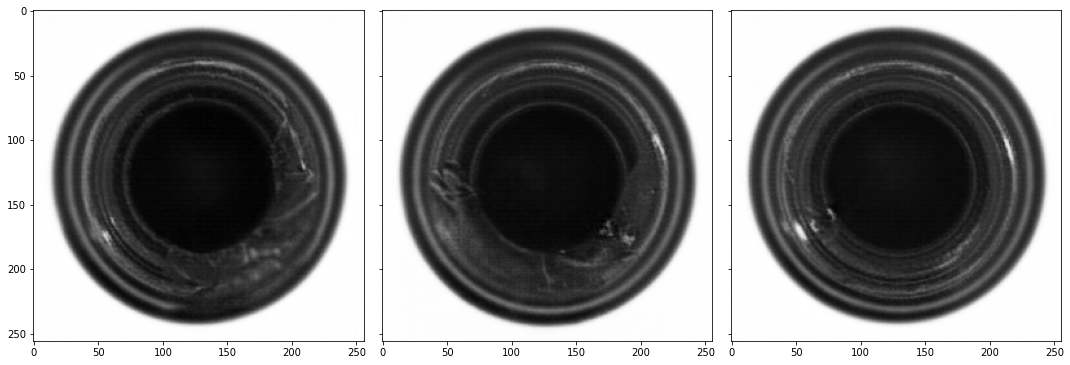

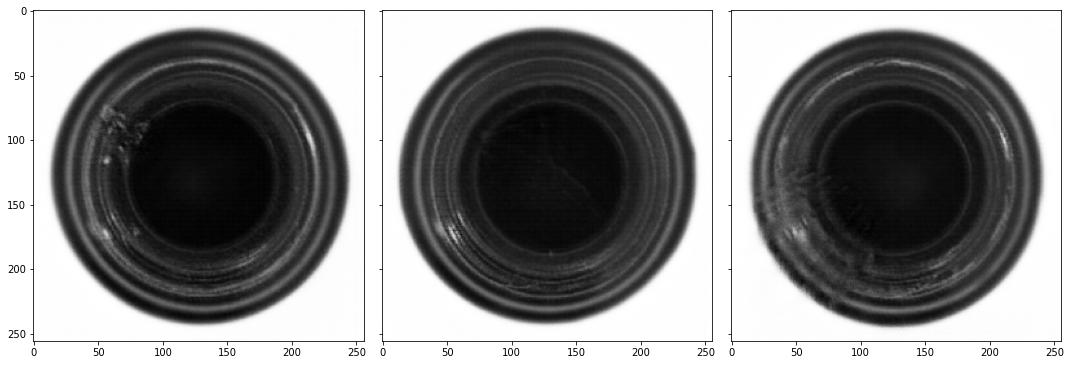


Sample Prediction after epoch 101

Epoch 101/300
11/11 [==============================] - 7s 639ms/step - loss: 4.6465e-04 - val_loss: 4.7723e-04
Epoch 102/300
11/11 [==============================] - 7s 638ms/step - loss: 4.6416e-04 - val_loss: 4.7393e-04
Epoch 103/300
11/11 [==============================] - 7s 634ms/step - loss: 4.5202e-04 - val_loss: 4.9693e-04
Epoch 104/300
11/11 [==============================] - 7s 628ms/step - loss: 4.4691e-04 - val_loss: 6.6668e-04
Epoch 105/300
11/11 [==============================] - 7s 635ms/step - loss: 4.6863e-04 - val_loss: 5.4803e-04
Epoch 106/300
11/11 [==============================] - 7s 633ms/step - loss: 4.9185e-04 - val_loss: 5.6985e-04
Epoch 107/300
11/11 [==============================] - 7s 632ms/step - loss: 4.6846e-04 - val_loss: 5.0440e-04
Epoch 108/300
11/11 [==============================] - 7s 677ms/step - loss: 4.3078e-04 - val_loss: 4.5677e-04
Epoch 109/300
11/11 [==============================] - 7s 636ms/step - loss:

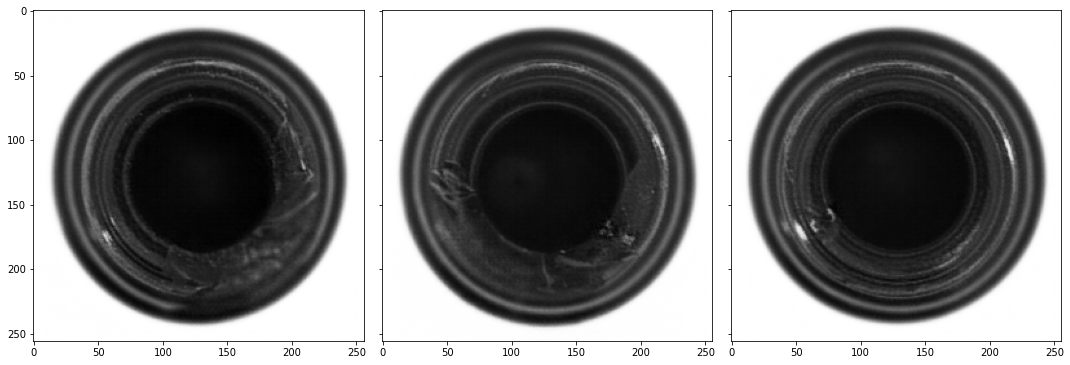

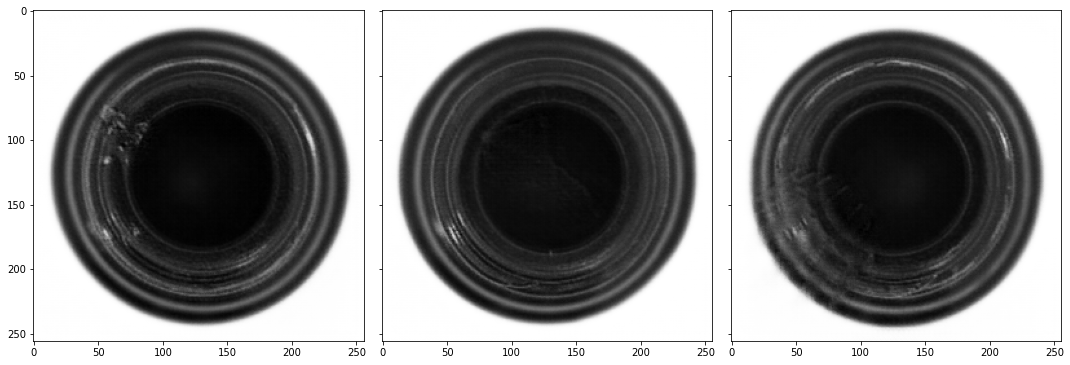


Sample Prediction after epoch 151

Epoch 151/300
11/11 [==============================] - 7s 639ms/step - loss: 3.5080e-04 - val_loss: 3.7717e-04
Epoch 152/300
11/11 [==============================] - 7s 634ms/step - loss: 3.4965e-04 - val_loss: 3.4656e-04
Epoch 153/300
11/11 [==============================] - 7s 680ms/step - loss: 3.5567e-04 - val_loss: 3.4229e-04
Epoch 154/300
11/11 [==============================] - 7s 634ms/step - loss: 3.5348e-04 - val_loss: 3.9158e-04
Epoch 155/300
11/11 [==============================] - 7s 640ms/step - loss: 3.5570e-04 - val_loss: 3.4971e-04
Epoch 156/300
11/11 [==============================] - 7s 641ms/step - loss: 3.6462e-04 - val_loss: 3.5485e-04
Epoch 157/300
11/11 [==============================] - 7s 636ms/step - loss: 3.3799e-04 - val_loss: 3.8221e-04
Epoch 158/300
11/11 [==============================] - 8s 694ms/step - loss: 3.5296e-04 - val_loss: 3.2946e-04
Epoch 159/300
11/11 [==============================] - 7s 633ms/step - loss:

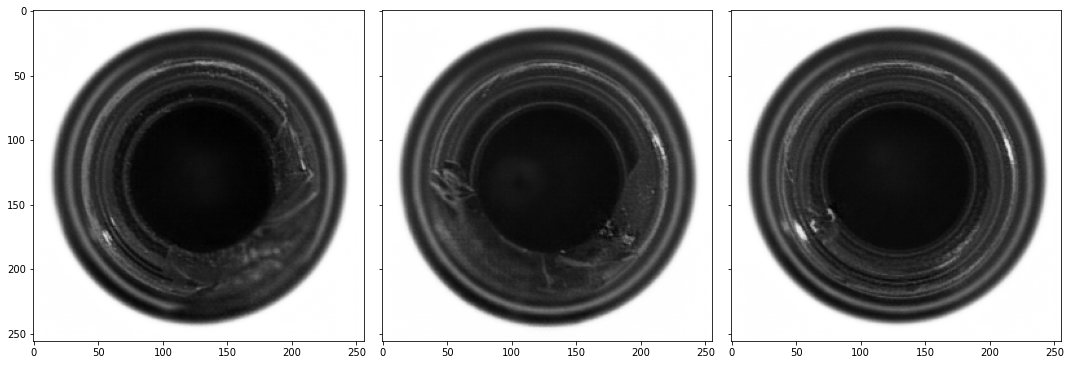

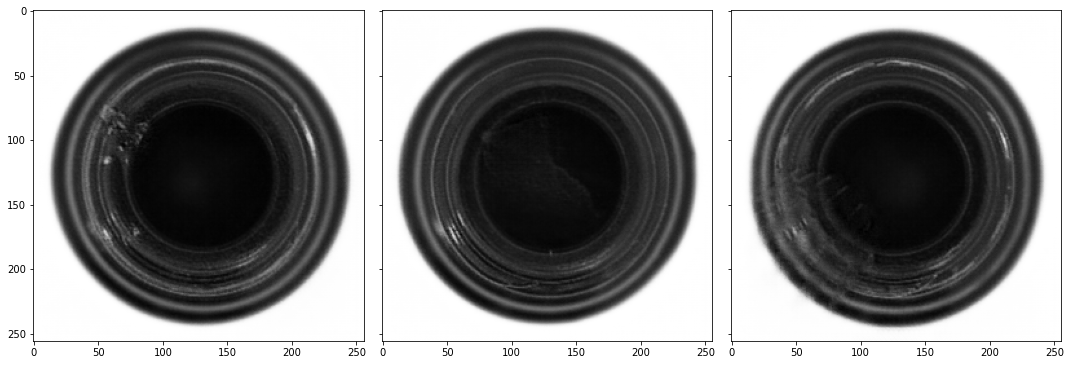


Sample Prediction after epoch 201

Epoch 201/300
11/11 [==============================] - 7s 640ms/step - loss: 3.1787e-04 - val_loss: 3.3248e-04
Epoch 202/300
11/11 [==============================] - 8s 685ms/step - loss: 3.0580e-04 - val_loss: 3.0331e-04
Epoch 203/300
11/11 [==============================] - 7s 630ms/step - loss: 3.1185e-04 - val_loss: 3.2391e-04
Epoch 204/300
11/11 [==============================] - 7s 632ms/step - loss: 3.0060e-04 - val_loss: 3.4695e-04
Epoch 205/300
11/11 [==============================] - 7s 639ms/step - loss: 3.0728e-04 - val_loss: 3.2250e-04
Epoch 206/300
11/11 [==============================] - 7s 668ms/step - loss: 3.0739e-04 - val_loss: 3.0628e-04
Epoch 207/300
11/11 [==============================] - 8s 686ms/step - loss: 3.0782e-04 - val_loss: 2.9768e-04
Epoch 208/300
11/11 [==============================] - 7s 640ms/step - loss: 3.0458e-04 - val_loss: 3.0703e-04
Epoch 209/300
11/11 [==============================] - 7s 637ms/step - loss:

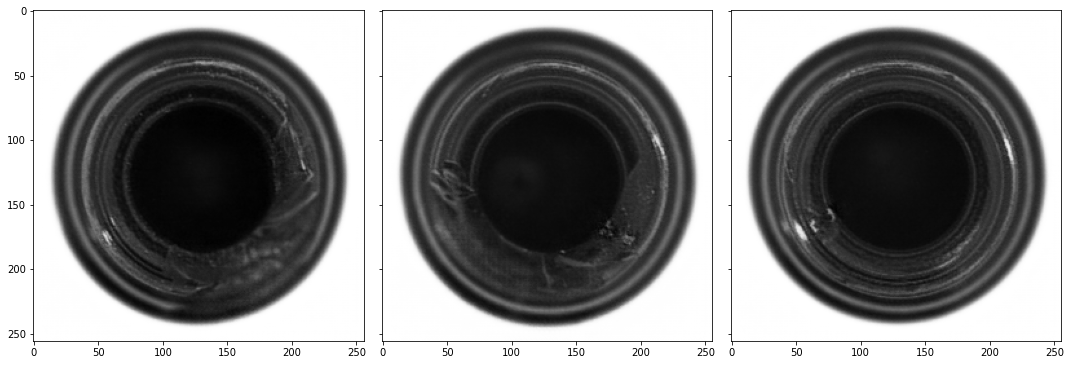

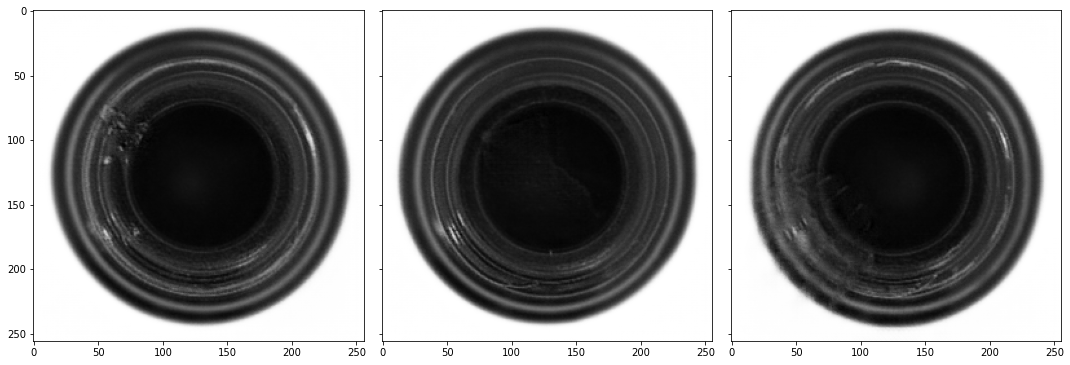


Sample Prediction after epoch 251

Epoch 251/300
11/11 [==============================] - 7s 633ms/step - loss: 2.7797e-04 - val_loss: 2.9716e-04
Epoch 252/300
11/11 [==============================] - 7s 634ms/step - loss: 2.9364e-04 - val_loss: 2.9349e-04
Epoch 253/300
11/11 [==============================] - 7s 637ms/step - loss: 2.7779e-04 - val_loss: 3.0562e-04
Epoch 254/300
11/11 [==============================] - 7s 632ms/step - loss: 2.9136e-04 - val_loss: 2.9657e-04
Epoch 255/300
11/11 [==============================] - 7s 635ms/step - loss: 2.8637e-04 - val_loss: 3.0556e-04
Epoch 256/300
11/11 [==============================] - 7s 634ms/step - loss: 2.8974e-04 - val_loss: 2.9914e-04
Epoch 257/300
11/11 [==============================] - 7s 633ms/step - loss: 2.9598e-04 - val_loss: 3.0909e-04
Epoch 258/300
11/11 [==============================] - 7s 634ms/step - loss: 2.8698e-04 - val_loss: 2.8520e-04
Epoch 259/300
11/11 [==============================] - 7s 639ms/step - loss:

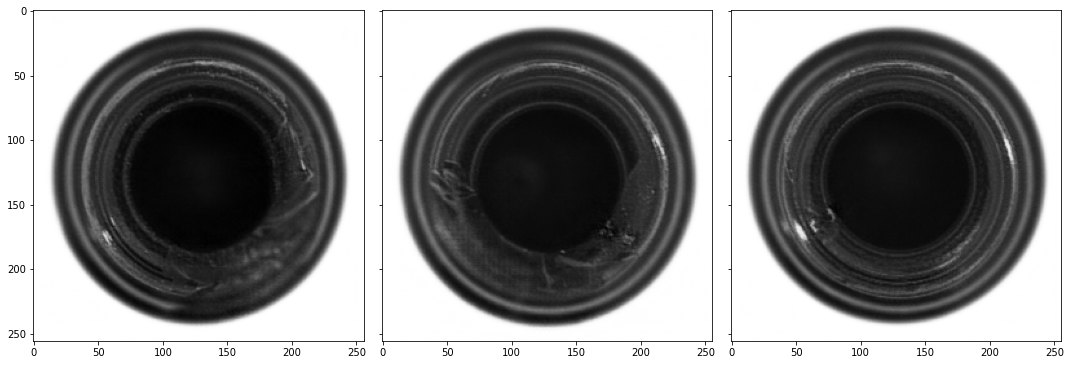

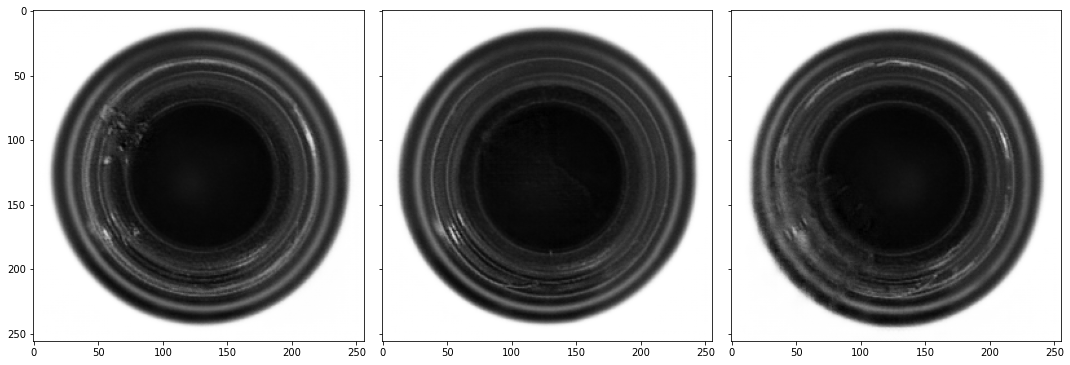

In [187]:
# from keras_adabound import AdaBound

print('[INFO] building autoencoder...')
K.clear_session()
# autoencoder=TutorialUnet(3)
autoencoder = create_autoencoder()  
lr_schedule = tf.keras.experimental.CosineDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=EPOCHS * trainX.shape[0] // BS)
opt=Adam(learning_rate=lr_schedule)
autoencoder.compile(loss=LOSS, optimizer=opt)


'''
ADABOUND
'''
# WEIGHT_DECAY = 1e-6
# regularizer = tf.keras.regularizers.l2(WEIGHT_DECAY / 2)
# for layer in autoencoder.layers:
#     for attr in ['kernel_regularizer', 'bias_regularizer']:
#         if hasattr(layer, attr) and layer.trainable:
#             setattr(layer, attr, regularizer)
            
# autoencoder.compile(optimizer = AdaBound(lr=INIT_LR, final_lr=0.1),
#               loss = 'mse')
''''''
autoencoder.summary()

# callbacks=[
#     TensorBoard(
#     log_dir=args['output_path'], histogram_freq=0, write_graph=True, write_images=False,
#     update_freq='epoch', profile_batch=2, embeddings_freq=0,
#     embeddings_metadata=None)   
# ]
def show_predictions(model, inputs, preds):
    prediction = model.predict(inputs)
    fig, axes = plt.subplots(1, preds, sharex=True, sharey=True, figsize=(15,15))
    for i in range(preds):
        axes[i].imshow(prediction[i])
    plt.tight_layout()
    plt.show()
    
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % 50 == 0:
            show_predictions(self.model, visImages[:3], 3)
            show_predictions(self.model, visImages[3:], 3)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

checkpoint_filepath = './outputs/temp_weights/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

print('[INFO] training autoencoder...')
H=autoencoder.fit(
    trainData,
    validation_data=valData,
    epochs=EPOCHS,
    callbacks=[DisplayCallback(), model_checkpoint_callback]
)

print('[INFO] loading best weights and cleanup')
autoencoder.load_weights(checkpoint_filepath)
!rm -rf {checkpoint_filepath}/*

print('[INFO] Saving model...')
autoencoder.save(modelSavePath)

print('Final Prediction:')
show_predictions(autoencoder, visImages[:3], 3)
show_predictions(autoencoder, visImages[3:], 3)

In [193]:
autoencoder = tf.keras.models.load_model(modelSavePath)

0.30303764

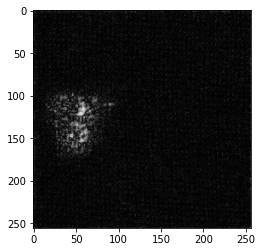

In [11]:
# Evaluation pipeline
i = 0
# thresh = 0.05
out = autoencoder(visImages[i:i+1])
res = np.abs(out[0] - visImages[i])
# res[res < thresh] = 0
# res[res >= thresh] = 1
# res = cv2.GaussianBlur(res,(7,7),0)
plt.imshow(res)
np.max(res)

In [30]:
x = np.ones(res.shape).astype('uint8')
x.shape
x.flatten()

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [41]:
m = tf.keras.metrics.AUC()
m.update_state([0, 0, 0], [0, 0, 0])
m.result().numpy()

0.0

In [52]:
res

array([[[0.1042902 ],
        [0.07346354],
        [0.03844734],
        ...,
        [0.0415709 ],
        [0.00033788],
        [0.04962757]],

       [[0.05720602],
        [0.01343174],
        [0.06251498],
        ...,
        [0.02164902],
        [0.0305465 ],
        [0.00646758]],

       [[0.00109372],
        [0.04270801],
        [0.01656552],
        ...,
        [0.02769084],
        [0.00402649],
        [0.01949453]],

       ...,

       [[0.01617214],
        [0.01174727],
        [0.00248268],
        ...,
        [0.00747791],
        [0.0142965 ],
        [0.00202699]],

       [[0.036836  ],
        [0.00392231],
        [0.01301971],
        ...,
        [0.01923168],
        [0.0138831 ],
        [0.0515831 ]],

       [[0.04736647],
        [0.0730775 ],
        [0.03487152],
        ...,
        [0.03018627],
        [0.0299256 ],
        [0.10025512]]], dtype=float32)

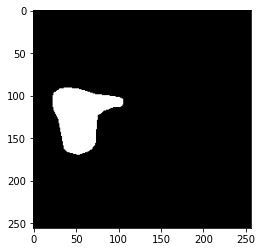

In [86]:
gt = '/home/sam/transfer-learning-autoencoders/data/mvtec_anomaly_detection/carpet/ground_truth/cut/000_mask.png'
gt = cv2.imread(gt)
gt = cv2.resize(gt, (DIM, DIM))
gt = gt[...,0]
gt[gt > 0] = 1
plt.imshow(gt)

In [87]:
roc_auc_score(gt.flatten(), res.flatten())

0.8548956858520659

[INFO] Running predictions...


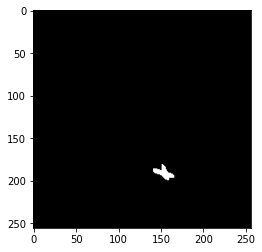

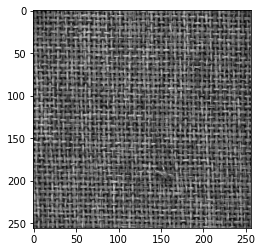

[INFO] Evaluating results...


0.8040516565244512

In [127]:
object_path  = 'data/mvtec_anomaly_detection/carpet/'
ground_path  = os.path.join(object_path, 'ground_truth')
images_path  = os.path.join(object_path, 'test')
defect_types = os.listdir(ground_path)

ground_vector = []
input_images  = []

for defect_type in defect_types:
    masks  = sorted(os.listdir(os.path.join(ground_path, defect_type)))
    images = sorted(os.listdir(os.path.join(images_path, defect_type)))
    for mask in masks:
        full_path = os.path.join(ground_path, defect_type, mask)
        ground = cv2.imread(full_path)[...,0]
        ground = cv2.resize(ground, (DIM, DIM))
        ground[ground > 0] = 1
        ground_vector.append(ground)
    for image in images:
        full_path = os.path.join(images_path, defect_type, image)
        image = cv2.imread(full_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (DIM, DIM)).astype('float32') / 255
        input_images.append(image)

# Predict images
print('[INFO] Running predictions...')
input_images = np.array(input_images)
results_vector = autoencoder(input_images).numpy()
results_vector = np.squeeze(results_vector, axis=-1)


plt.imshow(ground_vector[14])
plt.show()
plt.imshow(input_images[14])
plt.show()
print('[INFO] Evaluating results...')
results_vector = np.abs(results_vector - input_images).flatten()
ground_vector = np.array(ground_vector).flatten()
roc_auc_score(ground_vector, results_vector)

In [188]:
def get_auc(object_path, autoencoder, method, model_function=None):
    
    ground_path  = os.path.join(object_path, 'ground_truth')
    images_path  = os.path.join(object_path, 'test')
    defect_types = os.listdir(ground_path)

    if method == 'uncertainty':
        print('[INFO]: Generating uncertainty model')
        assert model_function is not None, 'Must provide function that autoencoder was created with if using uncertainty method'
        weights = autoencoder.get_weights()
        uncertainty_ae = model_function(MCDropout=True)
        uncertainty_ae.set_weights(weights)
        
    # Calculate the overall AUC separately. Averaging the AUC's for individual categories gives
    # a slightly higher score.
    all_ground  = []
    all_results = []
    for defect_type in defect_types:
        ground_vector = []
        input_images  = []
        masks  = sorted(os.listdir(os.path.join(ground_path, defect_type)))
        images = sorted(os.listdir(os.path.join(images_path, defect_type)))
        for mask in masks:
            full_path = os.path.join(ground_path, defect_type, mask)
            ground = cv2.imread(full_path)[...,0]
            ground = cv2.resize(ground, (DIM, DIM))
            ground[ground > 0] = 1
            ground_vector.append(ground)
        for image in images:
            full_path = os.path.join(images_path, defect_type, image)
            image = cv2.imread(full_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (DIM, DIM)).astype('float32') / 255
            input_images.append(image)

        # Predict images
        input_images = np.array(input_images)
        if method =='uncertainty':
            results_list = []
            # Using 30 runs according to the paper
            for i in range(30):
                results = uncertainty_ae(input_images).numpy()
                results = np.squeeze(results, axis=-1)
                results_list.append(results)
            results_vector = np.std(results_list, axis=0)
            plt.imshow(results_vector[0])
            plt.show()
            results_vector = results_vector.flatten()
        else:
            results_vector = autoencoder(input_images).numpy()
            results_vector = np.squeeze(results_vector, axis=-1)
            results_vector = np.abs(results_vector - input_images).flatten()
        ground_vector = np.array(ground_vector).flatten()
        score = roc_auc_score(ground_vector, results_vector)
        print(f'AUC for {defect_type}:', score)

        for i in ground_vector: all_ground.append(i)
        for i in results_vector: all_results.append(i)

    full_score = roc_auc_score(all_ground, all_results)
    print('Average AUC score:', full_score)

[INFO]: Generating uncertainty model


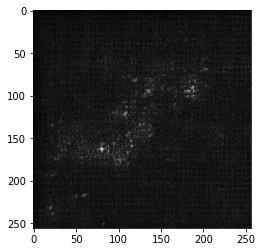

AUC for metal_contamination: 0.9734241757693327


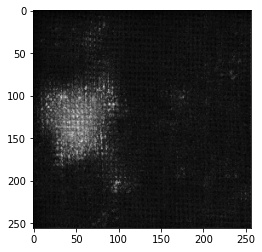

AUC for cut: 0.9402999011633814


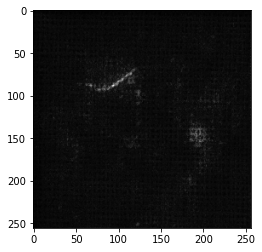

AUC for thread: 0.8713199568627232


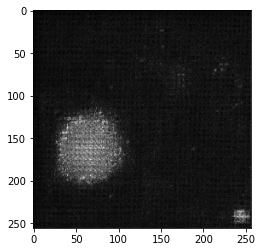

AUC for color: 0.9673412984405653


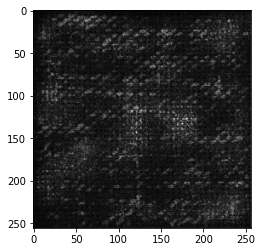

AUC for hole: 0.952146704126535
Average AUC score: 0.9429134898567944


In [195]:
object_path  = 'data/mvtec_anomaly_detection/carpet/'
get_auc(object_path, autoencoder, method='uncertainty', model_function=create_autoencoder)

In [ ]:
plt.plot(H.history['loss'])
with open(historySavePath, 'wb') as file_pi:
    pickle.dump(H.history, file_pi)

In [ ]:
K.clear_session()
autoencoder = tf.keras.models.load_model(modelSavePath)

In [ ]:
# Test on val images
for batch in valData:
    img = batch[0][:1]
    target = batch[1][0]
    pred = autoencoder.predict(img)[0]
    
    resid = np.abs(pred - img[0])
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,15))
    axes[0].imshow(img[0])
    axes[1].imshow(pred)
    axes[2].imshow(resid)
    

In [ ]:
# Test on test images
TEST_DIR = 'data/mvtec_anomaly_detection/carpet/test/cut/'
testImgs = os.listdir(TEST_DIR)
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))

for imgName in testImgs:
    img = cv2.imread(os.path.join(TEST_DIR, imgName))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (DIM, DIM)).astype('float32') / 255
    
    pred = autoencoder.predict(np.expand_dims(img, axis=0))[0]
    
    resid = (np.abs(pred - img) * 255).astype('uint8')
    for channel in range(3):
        resid[..., channel] = clahe.apply(resid[..., channel])
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,15))
    axes[0].imshow(img)
    axes[1].imshow(pred)
    axes[2].imshow(resid)
    

## LOG

- __v0__ Interestingly, gets really good at epoch 50 then starts to just straight up reproduce errors. Maybe just trained for too long? Or need to be more aggressive with staining? TLoss to 2.2136e-04, VLoss to 2.8629e-04.
    - Hm, looking at the val data, it looks like it's just putting the same pattern under every stain. Not necessarily bad lol it is a uniform pattern after all. But could it just be learning to plug in something generic and that's why when we feed it an actual hole it just spits it out. First thing to try is stopping the training at 50 epochs. Next is to actually be LESS aggressive with staining size.
    - HOWEVER, barring a few cases, the residual actually grabs the defective area pretty well.
- __v1__ Hm, the coloration is off. TL to 5.1752e-04, VL to 0.0033. Trained for 100 because learning rate decay. Let's try being less aggro with staining. Size is probably ok, but limit the colors.